In [4]:
## previous notebook had gotten out of hand - reimporting the processing with only key aspects so I can focus on modeling

In [1]:
from datetime import datetime, timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats as stats
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline

import networkx as nx
from networkx.algorithms.components.connected import connected_components

%matplotlib notebook
%timeit

#show up to 100 columns.
pd.set_option('display.max_columns', 100)

In [2]:
data_file = "new_theorem_data.p"

## data appears to have been savied in Python 2 - changing encoding allows us to properly load data
with open(data_file, 'rb') as pickle_file:
    data = pickle.load(pickle_file, encoding='latin1') 

<IPython.core.display.Javascript object>


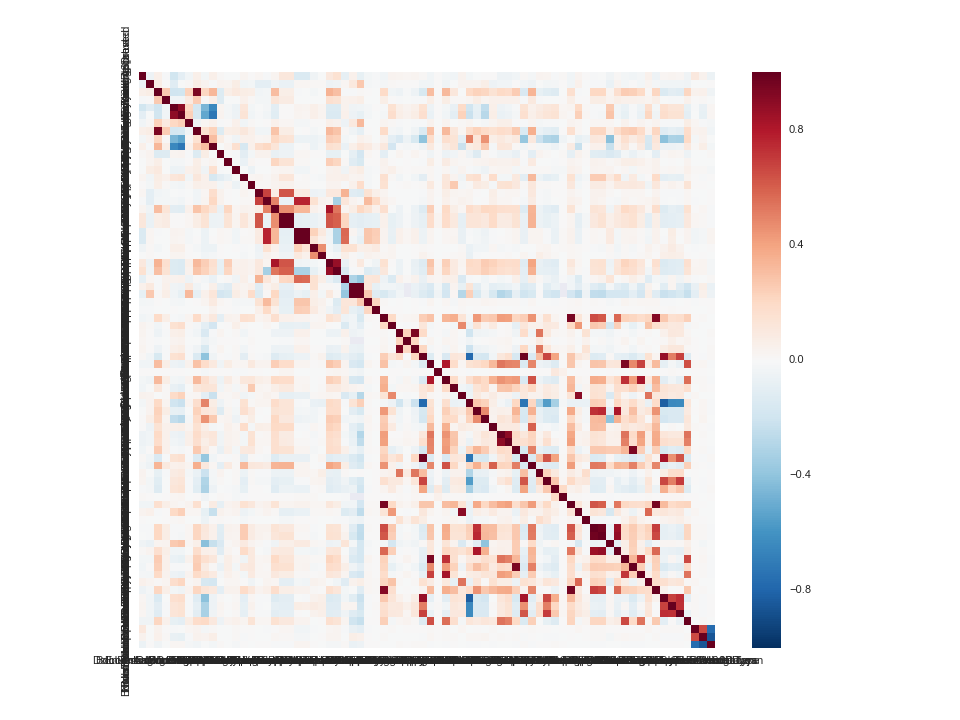

In [3]:
## find correlation of each of the variables with one another
corr = data.corr()

## 86 different categories - start by taking correlation matrix to figure out which categories are redundant
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corr, square=True)

In [4]:
corr['EnumListingStatus']

ListingID                                  -0.047446
EnumListingStatus                           1.000000
DolLoanAmountRequested                      0.075315
BoolPartialFundingApproved                  0.000953
LenderYield                                -0.121828
BorrowerRate                               -0.006793
NumMonthsTerm                               0.014387
DolMonthlyLoanPayment                       0.077843
FICOScore                                   0.037387
ProsperScore                               -0.011962
EnumListingCategory                         0.034750
DolMonthlyIncome                            0.024876
BoolIncomeVerifiable                        0.071998
FracDebtToIncomeRatio                      -0.035491
NumMonthsEmployed                          -0.027026
NumPriorProsperLoansActive                 -0.094263
NumPriorProsperLoans                       -0.095947
DolPriorProsperLoansPrincipalBorrowed      -0.046296
DolPriorProsperLoansPrincipalOutstanding   -0.

In [5]:
## thank you to stack overflow for the elegant solution: 
## http://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
def to_graph(l):
    G = nx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def to_edges(l):
    """ 
        treat `l` as a Graph and returns it's edges 
        to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
    """
    it = iter(l)
    last = next(it)

    for current in it:
        yield last, current
        last = current    

In [6]:
print(data['NumPriorProsperLoans'][:10])
print(data['NumPriorProsperLoansLateCycles'][:10])

ListingNumber
973605     0
981099     0
1025766    3
1003835    0
1011335    1
1010105    0
1029573    1
1014296    0
1009580    0
743482     0
Name: NumPriorProsperLoans, dtype: int64
ListingNumber
973605     NaN
981099     NaN
1025766    0.0
1003835    NaN
1011335    2.0
1010105    NaN
1029573    0.0
1014296    NaN
1009580    NaN
743482     NaN
Name: NumPriorProsperLoansLateCycles, dtype: float64


In [7]:
## cutoff of .6 recovers 47 inter-connected variables, .5 recovers 52, .55 recovers 50
## cutoff of .55 features largest group at length 10 - probably don't want to exceed that
tentative_families = []
cutoff = .55

for name, col in corr.iteritems():
    
    highly_correlated = (abs(col) > cutoff) & (col.index != name)
    high_corr_list = col[highly_correlated].index.tolist()
    
    if high_corr_list != []:
        tentative_families.append(sorted(high_corr_list + [ name ]))
        
tentative_families.sort()
tentative_families = list(tentative_families for tentative_families,_ in itertools.groupby(tentative_families))

for fam in sorted(tentative_families):
    print(fam)

['BoolEverWholeLoan', 'BoolIsFractionalLoan', 'EnumLoanFractionalType']
['BoolOwnsHome', 'DolMonthlyDebt', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalPaymentAllOpenTrades6']
['BoolOwnsHome', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalPaymentAllOpenTrades6']
['BoolOwnsHome', 'DolRealEstateBalance', 'DolTotalBalanceAllOpenTrades6', 'DolTotalPaymentAllOpenTrades6']
['BorrowerRate', 'LenderYield', 'ProsperScore']
['DolLoanAmountRequested', 'DolMonthlyLoanPayment']
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalBorrowed', 'DolPriorProsperLoansPrincipalOutstanding']
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalOutstanding']
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrinci

In [8]:
## key code that combines lists that share a common element.
G = to_graph(tentative_families)
cc = nx.connected_components(G)
families = []

for nodes in cc:
    families.append(list(nodes))
    
families = sorted([ sorted(fam) for fam in families ])
    
for fam in families:
    print(fam, len(fam))
    
ll = [ len(fam) for fam in families ]
print(sum(ll))

['BoolEverWholeLoan', 'BoolIsFractionalLoan', 'EnumLoanFractionalType'] 3
['BoolOwnsHome', 'DolMonthlyDebt', 'DolRealEstateBalance', 'DolRealEstatePayment', 'DolTotalBalanceAllOpenTrades6', 'DolTotalBalanceInstallTradesReptd6', 'DolTotalPaymentAllOpenTrades6'] 7
['BorrowerRate', 'LenderYield', 'ProsperScore'] 3
['DolLoanAmountRequested', 'DolMonthlyLoanPayment'] 2
['DolMaxPriorProsperLoan', 'DolMinPriorProsperLoan', 'DolPriorProsperLoansBalanceOutstanding', 'DolPriorProsperLoansPrincipalBorrowed', 'DolPriorProsperLoansPrincipalOutstanding', 'NumPriorProsperLoans', 'NumPriorProsperLoansActive', 'NumPriorProsperLoansCyclesBilled', 'NumPriorProsperLoansEarliestPayOff', 'NumPriorProsperLoansOnTimePayments'] 10
['DolRevolvingBalance', 'DolTotalBalanceOpenRevolving6'] 2
['NumBankcardTradesOpened12', 'NumCreditLines84', 'NumCurrentCreditLines', 'NumOpenCreditLines', 'NumOpenRevolvingAccounts', 'NumSatisfactoryAccounts', 'NumTrades'] 7
['NumDelinquencies84', 'NumDelinquenciesOver30Days', 'NumD

In [9]:
## give custom descriptive names to each family
# two items: first, each unit in the family; second, the variable(s) you're going to keep around.
family_dict = {}
family_dict['fractional_loan'] = [families[0],'BoolEverWholeLoan']
family_dict['debt'] = [families[1],'DolMonthlyDebt']
family_dict['borrower_rate'] = [families[2],'BorrowerRate']
family_dict['loan_amount'] = [families[3],'DolLoanAmountRequested']
## previously used DolPriorProsperLoansPrincipalBorrowed for representative prosper_history variable, but unideal
## because it has NaNs - whereas NumPriorProsperLoans does not
family_dict['prosper_history'] = [families[4],'NumPriorProsperLoans']
family_dict['revolving_balance'] = [families[5],'DolTotalBalanceOpenRevolving6']
family_dict['credit'] = [families[6],'NumCurrentCreditLines']
family_dict['delinquencies'] = [families[7],'PctTradesNeverDelinquent']
family_dict['inquiries'] = [families[8],'NumTotalInquiries']
family_dict['prior_prosper_loans'] = [families[9],'NumPriorProsperLoans61dpd']
family_dict['real_estate'] = [families[10],'NumRealEstateTrades']
family_dict['current_delinquency'] = [families[11],'NumTradesCurr30DPDOrDerog6']

In [10]:
## create reduced data set by dropping headers...
reduced_data = pd.DataFrame.copy(data, deep = True)

## immediately drop columns that are unlikely/unable to cause loan cancellation (ID numbers/dates)
drop_cols = ['ListingID', 'DateCreditPulled', 'DateListingStart', 'DateListingCreation', 'DateWholeLoanStart', 'DateWholeLoanEnd']
reduced_data.drop(drop_cols, axis = 1, inplace = True)

In [11]:
## drop similar columns as determined by families
for fam, items in family_dict.items():
    drop_cols = list(items[0])
    drop_cols.remove(items[1]) #keep our chosen representative variable for that family
    reduced_data.drop(drop_cols, axis = 1, inplace = True)

In [12]:
## manually drop a few other columns that won't help our analysis...
reduced_data.drop(['StrState','StrBorrowerCity','BoolIncomeVerifiable'], axis=1, inplace=True)

In [13]:
## replace DateFirstCredit column with an integer
days_since_firstcredit = datetime.now()-reduced_data['DateFirstCredit']
reduced_data['DaysSinceFirstCredit'] = [ x.days for x in days_since_firstcredit ]
reduced_data.drop('DateFirstCredit', axis=1, inplace=True)

<IPython.core.display.Javascript object>


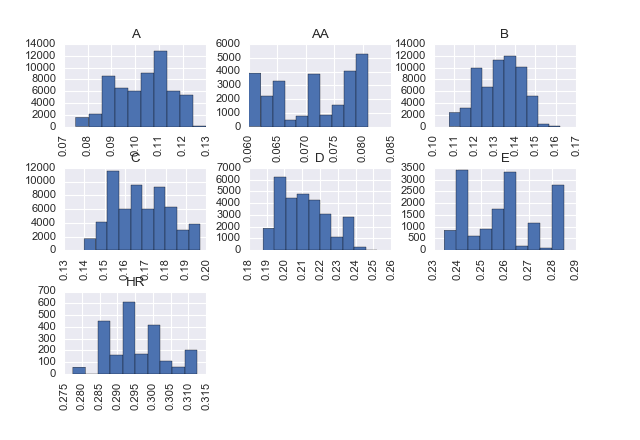

In [14]:
## quick plot to show that BorrowerRate and CreditGrade are pretty much equivalent - drop CreditGrade
reduced_data['BorrowerRate'].hist(by=reduced_data['CreditGrade'])
reduced_data.drop('CreditGrade',axis =1, inplace=True)

In [17]:
## Deal with remaining categorical variables - StrEmploymentStatus,StrOccupation,BoolInGroup and BoolEverWholeLoan
#pd.get_dummies(reduced_data['CreditGrade'])
label_encoder = preprocessing.LabelEncoder()

# Convert Sex variable to numeric
reduced_data["BoolInGroup"] = label_encoder.fit_transform(reduced_data["BoolInGroup"])
reduced_data["BoolEverWholeLoan"] = label_encoder.fit_transform(reduced_data["BoolEverWholeLoan"])
reduced_data.head()

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,BorrowerRate,NumMonthsTerm,FICOScore,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,DolPriorProsperLoansPrincipalBorrowed,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,DolTotalBalanceOnPublicRecords,AgeOldestTrade,PctTradesNeverDelinquent,DolTotalAvailBankcardCredit6,NumRealEstateTrades,DolTotalBalanceOpenRevolving6,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,NumCurrentCreditLines,PctBankcardUtil,NumTotalInquiries,BoolEverWholeLoan,DaysSinceFirstCredit
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,7,15000.0,True,0.1620,60,689,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,NaN,NaN,NaN,NaN,0,0,70000,1,0,0,0,419,96,439,2,33956,1242,0,0,0,0,11,0.97,5,1,13899
981099,7,15000.0,True,0.1585,60,709,1,7916.6667,0.35,Other,NaN,32.0,NaN,NaN,NaN,NaN,0,0,70000,1,0,0,0,430,100,9609,2,14852,2289,0,0,0,0,15,0.48,3,1,14236
1025766,6,4000.0,True,0.2085,36,669,1,2083.3333,0.53,Employed,Professional,4.0,14400.0,0.0,0.0,NaN,0,0,80000,0,0,0,0,100,86,1498,0,20802,911,0,0,0,0,8,0.93,5,0,4144
1003835,7,10000.0,True,0.1299,36,749,13,3750.0000,0.14,Employed,Medical Technician,2.0,NaN,NaN,NaN,NaN,0,0,90000,1,0,0,0,60,100,6050,0,3100,223,0,0,0,0,7,0.26,1,1,2940
1011335,6,20000.0,True,0.1440,60,649,1,9000.0000,0.16,Employed,Executive,90.0,2600.0,2.0,0.0,NaN,0,0,80000,1,0,0,1249,237,90,739,1,5519,1264,1,2,0,0,11,0.81,17,0,8327


In [15]:
## the probability of loan cancellation actually seems to vary a lot by profession
jobs = reduced_data.groupby('StrOccupation')
jobs['EnumListingStatus'].mean()[0:]

StrOccupation
Accountant/CPA                        6.289733
Administrative Assistant              6.305882
Analyst                               6.230218
Architect                             6.291925
Attorney                              6.319324
Biologist                             6.303191
Bus Driver                            6.424473
Car Dealer                            6.391241
Chemist                               6.314465
Civil Service                         6.231803
Clergy                                6.456621
Clerical                              6.309499
Computer Programmer                   6.227259
Construction                          6.397276
Dentist                               6.505556
Doctor                                6.417600
Engineer - Chemical                   6.364865
Engineer - Electrical                 6.269855
Engineer - Mechanical                 6.289251
Executive                             6.340349
Fireman                               6.290365

In [16]:
## some professions are more likely to be self-employed than others, but not a one-to-one match
jobs['StrEmploymentStatus'].value_counts(normalize = True)

StrOccupation                StrEmploymentStatus
Accountant/CPA               Employed               0.928640
                             Self-employed          0.065162
                             Full-time              0.003179
                             Other                  0.003020
Administrative Assistant     Employed               0.973428
                             Self-employed          0.018661
                             Full-time              0.006085
                             Other                  0.001826
Analyst                      Employed               0.983428
                             Self-employed          0.014631
                             Full-time              0.001792
                             Other                  0.000149
Architect                    Employed               0.902692
                             Self-employed          0.084886
                             Full-time              0.006211
                             Other  

In [17]:
#check if there are still NaN values left
reduced_data.isnull().any()

EnumListingStatus                   False
DolLoanAmountRequested              False
BoolPartialFundingApproved          False
BorrowerRate                        False
NumMonthsTerm                       False
FICOScore                           False
EnumListingCategory                 False
DolMonthlyIncome                    False
FracDebtToIncomeRatio                True
StrEmploymentStatus                 False
StrOccupation                        True
NumMonthsEmployed                    True
NumPriorProsperLoans                False
NumPriorProsperLoansLateCycles       True
NumPriorProsperLoansLatePayments     True
NumPriorProsperLoans61dpd            True
BoolIsLender                        False
BoolInGroup                         False
EnumChannelCode                     False
NumTradesOpened6                    False
NumOpenTradesDelinqOrPastDue6       False
NumTradesCurr30DPDOrDerog6          False
DolTotalBalanceOnPublicRecords      False
AgeOldestTrade                    

In [18]:
reduced_data.head()

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,BorrowerRate,NumMonthsTerm,FICOScore,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,NumPriorProsperLoans,NumPriorProsperLoansLateCycles,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,NumTradesCurr30DPDOrDerog6,DolTotalBalanceOnPublicRecords,AgeOldestTrade,PctTradesNeverDelinquent,DolTotalAvailBankcardCredit6,NumRealEstateTrades,DolTotalBalanceOpenRevolving6,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,NumCurrentCreditLines,PctBankcardUtil,NumTotalInquiries,BoolEverWholeLoan,DaysSinceFirstCredit
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,7,15000.0,True,0.1620,60,689,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,0,NaN,NaN,NaN,0,False,70000,1,0,0,0,419,96,439,2,33956,1242,0,0,0,0,11,0.97,5,True,13901
981099,7,15000.0,True,0.1585,60,709,1,7916.6667,0.35,Other,NaN,32.0,0,NaN,NaN,NaN,0,False,70000,1,0,0,0,430,100,9609,2,14852,2289,0,0,0,0,15,0.48,3,True,14238
1025766,6,4000.0,True,0.2085,36,669,1,2083.3333,0.53,Employed,Professional,4.0,3,0.0,0.0,NaN,0,False,80000,0,0,0,0,100,86,1498,0,20802,911,0,0,0,0,8,0.93,5,False,4146
1003835,7,10000.0,True,0.1299,36,749,13,3750.0000,0.14,Employed,Medical Technician,2.0,0,NaN,NaN,NaN,0,False,90000,1,0,0,0,60,100,6050,0,3100,223,0,0,0,0,7,0.26,1,True,2942
1011335,6,20000.0,True,0.1440,60,649,1,9000.0000,0.16,Employed,Executive,90.0,1,2.0,0.0,NaN,0,False,80000,1,0,0,1249,237,90,739,1,5519,1264,1,2,0,0,11,0.81,17,False,8329


<IPython.core.display.Javascript object>


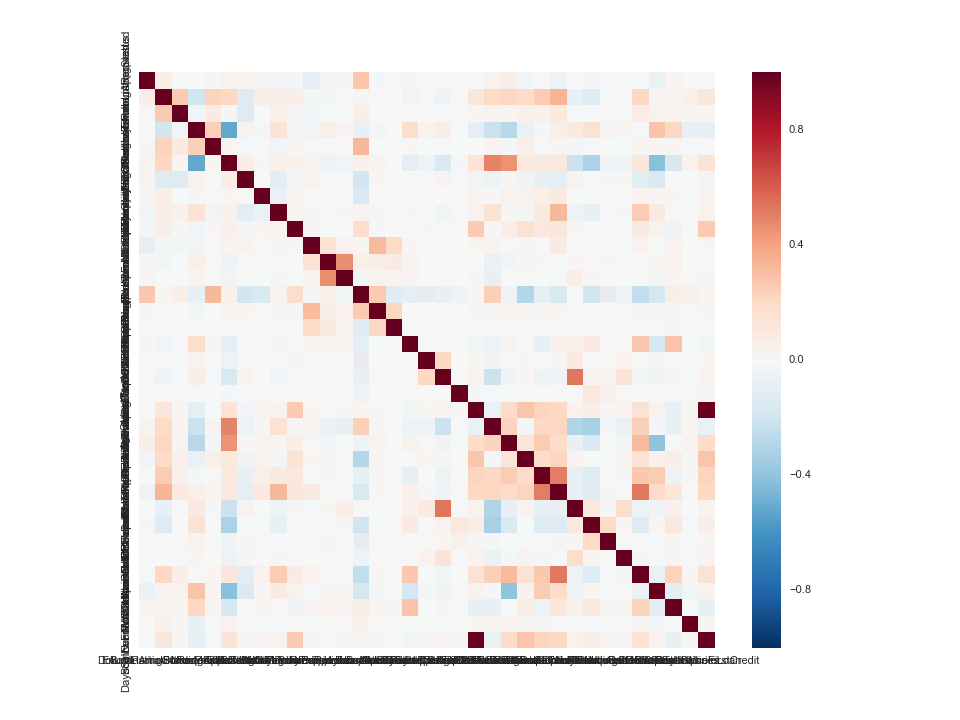

In [19]:
## let's parse out highly correlated variables one more time to get to reasonable set
reduced_corr = reduced_data.corr()

f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(reduced_corr, square=True)

In [20]:
reduced_corr['NumMonthsEmployed']

EnumListingStatus                  -0.027026
DolLoanAmountRequested              0.065185
BoolPartialFundingApproved          0.009350
BorrowerRate                       -0.036399
NumMonthsTerm                       0.012329
FICOScore                           0.054208
EnumListingCategory                -0.026419
DolMonthlyIncome                    0.019539
FracDebtToIncomeRatio               0.016427
NumMonthsEmployed                   1.000000
NumPriorProsperLoans                0.011255
NumPriorProsperLoansLateCycles     -0.003537
NumPriorProsperLoansLatePayments   -0.003407
NumPriorProsperLoans61dpd           0.180253
BoolIsLender                       -0.022372
BoolInGroup                        -0.004875
NumTradesOpened6                   -0.002686
NumOpenTradesDelinqOrPastDue6       0.009357
NumTradesCurr30DPDOrDerog6          0.005415
DolTotalBalanceOnPublicRecords      0.001335
AgeOldestTrade                      0.262377
PctTradesNeverDelinquent            0.008779
DolTotalAv

In [23]:
## cutoffs of .5, .45 and .4 all retrieve pretty similar stuff on second pass. let's stick with .45.
tentative_families = []
cutoff = .45

for name, col in reduced_corr.iteritems():
    
    highly_correlated = (abs(col) > cutoff) & (col.index != name)
    high_corr_list = col[highly_correlated].index.tolist()
    
    if high_corr_list != []:
        tentative_families.append(sorted(high_corr_list + [ name ]))
        
tentative_families.sort()
tentative_families = list(tentative_families for tentative_families,_ in itertools.groupby(tentative_families))

for fam in sorted(tentative_families):
    print(fam)

['AgeOldestTrade', 'DaysSinceFirstCredit']
['BorrowerRate', 'DolTotalAvailBankcardCredit6', 'FICOScore', 'PctTradesNeverDelinquent']
['BorrowerRate', 'FICOScore']
['DolMonthlyDebt', 'DolTotalBalanceOpenRevolving6']
['DolMonthlyDebt', 'DolTotalBalanceOpenRevolving6', 'NumCurrentCreditLines']
['DolMonthlyDebt', 'NumCurrentCreditLines']
['DolTotalAvailBankcardCredit6', 'FICOScore']
['FICOScore', 'PctTradesNeverDelinquent']
['NumCurrentDelinquencies', 'NumTradesCurr30DPDOrDerog6']
['NumPriorProsperLoansLateCycles', 'NumPriorProsperLoansLatePayments']


In [24]:
G = to_graph(tentative_families)
cc = nx.connected_components(G)
new_families = []

for nodes in cc:
    new_families.append(list(nodes))
    
new_families = sorted([ sorted(fam) for fam in new_families ])
    
for fam in new_families:
    print(fam, len(fam))
    
ll = [ len(fam) for fam in new_families ]
print(sum(ll))

['AgeOldestTrade', 'DaysSinceFirstCredit'] 2
['BorrowerRate', 'DolTotalAvailBankcardCredit6', 'FICOScore', 'PctTradesNeverDelinquent'] 4
['DolMonthlyDebt', 'DolTotalBalanceOpenRevolving6', 'NumCurrentCreditLines'] 3
['NumCurrentDelinquencies', 'NumTradesCurr30DPDOrDerog6'] 2
['NumPriorProsperLoansLateCycles', 'NumPriorProsperLoansLatePayments'] 2
13


In [25]:
## give custom descriptive names to each family
# two items: first, each unit in the family; second, the variable(s) you're going to keep around.
family_dict_2 = {}
family_dict_2['oldest_trade'] = [new_families[0],'DaysSinceFirstCredit']
family_dict_2['borrower_rate'] = [new_families[1],'BorrowerRate']
family_dict_2['monthly_debt'] = [new_families[2],'DolMonthlyDebt']
family_dict_2['current_delinquencies'] = [new_families[3],'NumCurrentDelinquencies']
family_dict_2['prosper_delinquencies'] = [new_families[4],'NumPriorProsperLoansLatePayments']

In [26]:
## again, drop similar columns as determined by families
for fam, items in family_dict_2.items():
    drop_cols = list(items[0])
    drop_cols.remove(items[1]) #keep our chosen representative variable for that family
    reduced_data.drop(drop_cols, axis = 1, inplace = True)

In [30]:
print("Number of columns:",len(reduced_data.columns.values))
reduced_data.head()

Number of columns: 30


,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,BorrowerRate,NumMonthsTerm,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,NumPriorProsperLoans,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,DolTotalBalanceOnPublicRecords,NumRealEstateTrades,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,PctBankcardUtil,NumTotalInquiries,BoolEverWholeLoan,DaysSinceFirstCredit
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,7,15000.0,True,0.1620,60,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,0,NaN,NaN,0,False,70000,1,0,0,2,1242,0,0,0,0,0.97,5,True,13900
981099,7,15000.0,True,0.1585,60,1,7916.6667,0.35,Other,NaN,32.0,0,NaN,NaN,0,False,70000,1,0,0,2,2289,0,0,0,0,0.48,3,True,14237
1025766,6,4000.0,True,0.2085,36,1,2083.3333,0.53,Employed,Professional,4.0,3,0.0,NaN,0,False,80000,0,0,0,0,911,0,0,0,0,0.93,5,False,4145
1003835,7,10000.0,True,0.1299,36,13,3750.0000,0.14,Employed,Medical Technician,2.0,0,NaN,NaN,0,False,90000,1,0,0,0,223,0,0,0,0,0.26,1,True,2941
1011335,6,20000.0,True,0.1440,60,1,9000.0000,0.16,Employed,Executive,90.0,1,0.0,NaN,0,False,80000,1,0,1249,1,1264,1,2,0,0,0.81,17,False,8328


In [56]:
reduced_data['Cancelled'] = reduced_data['EnumListingStatus']-6
reduced_data.drop('EnumListingStatus', axis=1, inplace = True)

In [57]:
reduced_data.to_pickle('theorem_reduced.pkl')

<IPython.core.display.Javascript object>


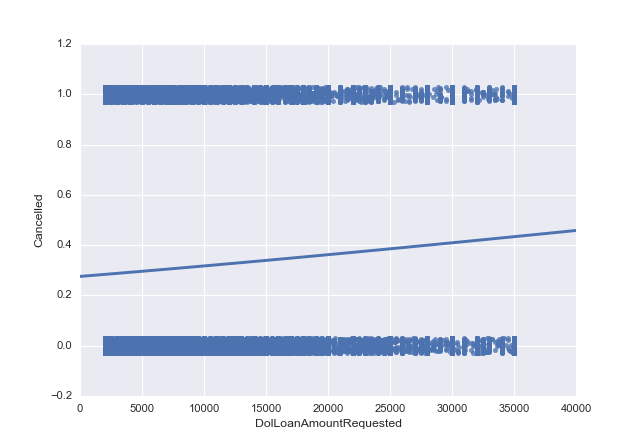

In [34]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
sns.regplot(x="DolLoanAmountRequested", y="Cancelled", data=reduced_data, logistic=True, y_jitter=.03, ci = None)

# Show the survival proability as a function of age and sex
#g = sns.lmplot(x="DolLoanAmountRequested", y="EnumListingStatus", data=reduced_data, logistic=True)
#g.set(xlim=(0, 80), ylim=(-.05, 1.05))

In [38]:
## 19 numerical variables only - show plot for each one. Also include column for cancellation.
numerics = reduced_data[['DolLoanAmountRequested','BorrowerRate','NumMonthsTerm','DolMonthlyIncome','FracDebtToIncomeRatio',\
'NumMonthsEmployed','NumPriorProsperLoans','NumPriorProsperLoansLatePayments',\
'NumTradesOpened6','NumOpenTradesDelinqOrPastDue6','DolTotalBalanceOnPublicRecords','NumRealEstateTrades',\
'DolMonthlyDebt','NumCurrentDelinquencies','NumPublicRecords12','DolAmountDelinquent','PctBankcardUtil',\
'NumTotalInquiries','DaysSinceFirstCredit','Cancelled']]

## 4 other boolean variables
booleans = reduced_data[['BoolPartialFundingApproved','BoolIsLender','BoolInGroup','BoolEverWholeLoan']]

## 4 categorical variables left: EnumListingCategory, StrEmploymentStatus, StrOccupation, EnumChannelCode

<IPython.core.display.Javascript object>


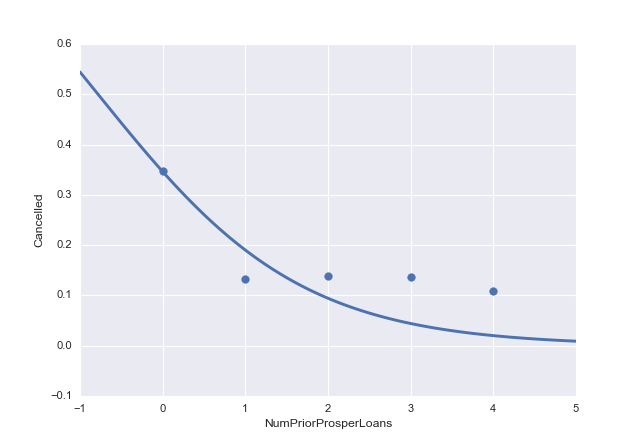

In [39]:
fig, axes = plt.subplots()
sns.regplot(x='NumPriorProsperLoans', y="Cancelled", data=reduced_data, logistic=True, y_jitter=.03, ci = None, x_bins = 1000)

<IPython.core.display.Javascript object>


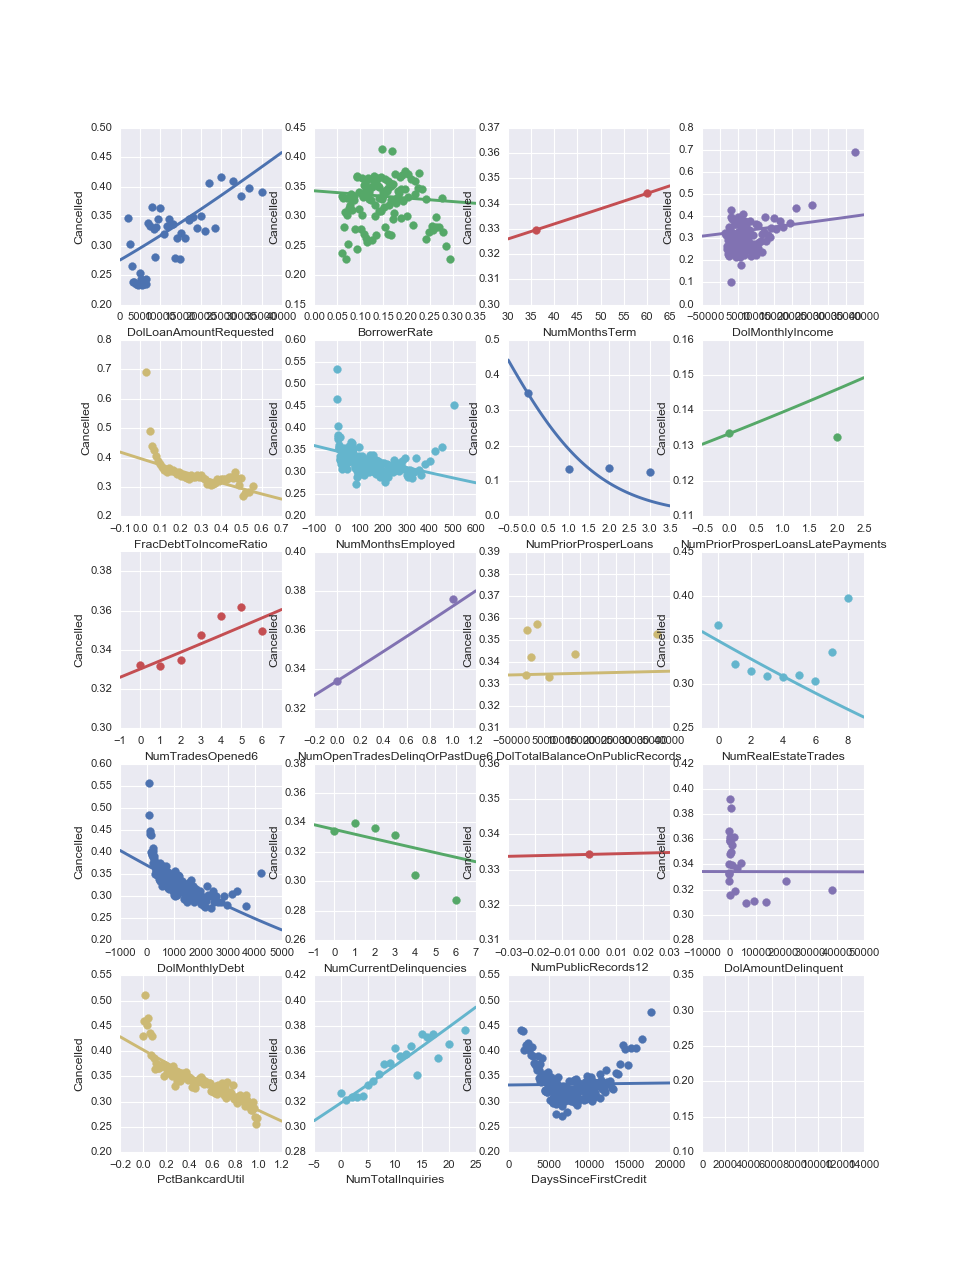

In [40]:
## create one big figure behind subpanels
fig, axes = plt.subplots(5,4,figsize=(12,16), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1)[:-1],numerics.columns.values[:-1]):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, y_jitter=.03, ci = None, x_bins = 200)
    
## LOOKS SIGNIFICANT: DolLoanAmountRequested, DolMonthlyIncome,FracDebtToIncomeRatio,NumMonthsEmployed,NumTradesOpened6,
## NumOpenTradesDelinqOrPastDue6, NumRealEstateTrades, DolMonthlyDebt, NumCurrentDelinquencies, PctBankcardUtil,
## NumTotalInquiries

## DaysSinceFirstCredit has notable parabolic behavior in probability space - may actually be more useful to convert
## to categorical behavior. Actually, same with NumMonthsEmployed?

## NumPriorProsperLoans is a TREMENDOUS predictor of not cancelling - if you've been through the process before, much
## easier to follow through. Not only that, but it should pretty clearly be a boolean cutoff variable - 

<IPython.core.display.Javascript object>


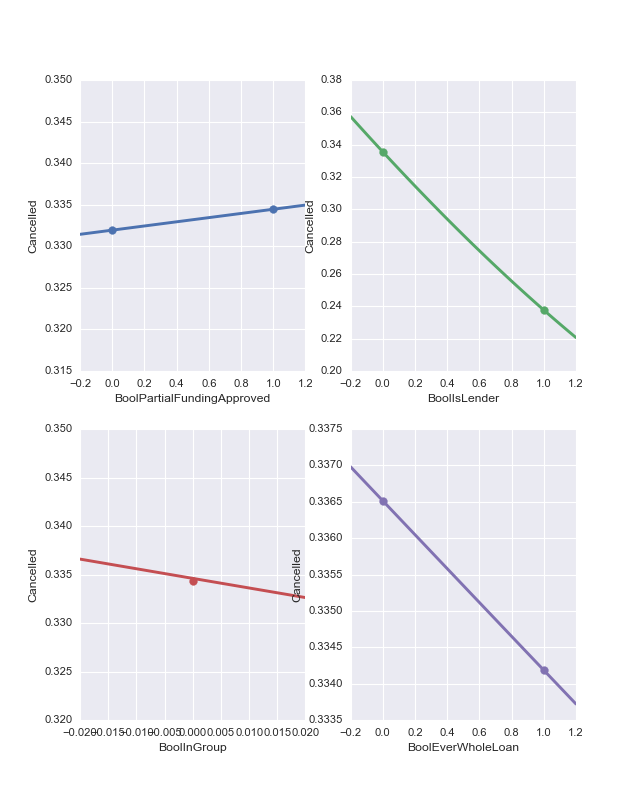

In [41]:
## create one big figure behind subpanels
fig, axes = plt.subplots(2,2,figsize=(8,10), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1), booleans.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, ci = None, x_bins = 200)
    
## CONCLUSION: BoolIsLender and BoolInGroup highly significant, BoolPartialFundingApproved and BoolEverWholeLoan not.

In [155]:
reduced_data['BoolInGroup'].value_counts()

0    251804
1       665
Name: BoolInGroup, dtype: int64

In [42]:
## Handle NaN values with sklearn's imputer - DolPriorProsperLoansPrincipalBorrowed, NumPriorProsperLoansLateCycles,
#NumPriorProsperLoansLatePayments and NumPriorProsperLoans61dpd

print(reduced_data.isnull().any())

## two more columns feature a small amount of NaNs: FracDebtToIncomeRatio and NumMonthsEmployed

##from looking at NumPriorProsperLoans61dpd, probably need to handle that variable differently - only 50 non-Nan values
## handle the first 3 variables together first.
imp = preprocessing.Imputer(missing_values="NaN",strategy='mean',axis=0)

#replace nans with column mean
test_out = imp.fit_transform(reduced_data[['NumPriorProsperLoansLateCycles',\
                     'NumPriorProsperLoansLatePayments','FracDebtToIncomeRatio','NumMonthsEmployed']])

reduced_data['NumPriorProsperLoansLateCycles'] = test_out[:,0]
reduced_data['NumPriorProsperLoansLatePayments'] = test_out[:,1]
reduced_data['FracDebtToIncomeRatio'] = test_out[:,2]
reduced_data['NumMonthsEmployed'] = test_out[:,3]

#Having a loan over 61 days past due is a rare event - should expect 0, not mean of actual observations!
reduced_data['NumPriorProsperLoans61dpd'].fillna(0, inplace = True)

EnumListingStatus                   False
DolLoanAmountRequested              False
BoolPartialFundingApproved          False
BorrowerRate                        False
NumMonthsTerm                       False
EnumListingCategory                 False
DolMonthlyIncome                    False
FracDebtToIncomeRatio                True
StrEmploymentStatus                 False
StrOccupation                        True
NumMonthsEmployed                    True
NumPriorProsperLoans                False
NumPriorProsperLoansLatePayments     True
NumPriorProsperLoans61dpd            True
BoolIsLender                        False
BoolInGroup                         False
EnumChannelCode                     False
NumTradesOpened6                    False
NumOpenTradesDelinqOrPastDue6       False
DolTotalBalanceOnPublicRecords      False
NumRealEstateTrades                 False
DolMonthlyDebt                      False
NumCurrentDelinquencies             False
NumPublicRecordsLast10Years       

KeyError: "['NumPriorProsperLoansLateCycles'] not in index"

In [43]:
reduced_data['PriorProsperLoanee'] = reduced_data['NumPriorProsperLoans'] > 0


In [44]:
reduced_data.drop('NumPriorProsperLoans', inplace = True, axis =1)

In [45]:
reduced_data['BoolPriorProsperLoanee'] = reduced_data['PriorProsperLoanee']
reduced_data.drop('PriorProsperLoanee', inplace = True, axis =1)

In [33]:
reduced_data['DolLoanAmountRequested'].shape

(252469,)

In [46]:
reduced_data.head()

,EnumListingStatus,DolLoanAmountRequested,BoolPartialFundingApproved,BorrowerRate,NumMonthsTerm,EnumListingCategory,DolMonthlyIncome,FracDebtToIncomeRatio,StrEmploymentStatus,StrOccupation,NumMonthsEmployed,NumPriorProsperLoansLatePayments,NumPriorProsperLoans61dpd,BoolIsLender,BoolInGroup,EnumChannelCode,NumTradesOpened6,NumOpenTradesDelinqOrPastDue6,DolTotalBalanceOnPublicRecords,NumRealEstateTrades,DolMonthlyDebt,NumCurrentDelinquencies,NumPublicRecordsLast10Years,NumPublicRecords12,DolAmountDelinquent,PctBankcardUtil,NumTotalInquiries,BoolEverWholeLoan,DaysSinceFirstCredit,Cancelled,BoolPriorProsperLoanee
ListingNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
973605,7,15000.0,True,0.1620,60,1,6000.0000,0.27,Employed,Tradesman - Mechanic,445.0,NaN,NaN,0,False,70000,1,0,0,2,1242,0,0,0,0,0.97,5,True,13901,1,False
981099,7,15000.0,True,0.1585,60,1,7916.6667,0.35,Other,NaN,32.0,NaN,NaN,0,False,70000,1,0,0,2,2289,0,0,0,0,0.48,3,True,14238,1,False
1025766,6,4000.0,True,0.2085,36,1,2083.3333,0.53,Employed,Professional,4.0,0.0,NaN,0,False,80000,0,0,0,0,911,0,0,0,0,0.93,5,False,4146,0,True
1003835,7,10000.0,True,0.1299,36,13,3750.0000,0.14,Employed,Medical Technician,2.0,NaN,NaN,0,False,90000,1,0,0,0,223,0,0,0,0,0.26,1,True,2942,1,False
1011335,6,20000.0,True,0.1440,60,1,9000.0000,0.16,Employed,Executive,90.0,0.0,NaN,0,False,80000,1,0,1249,1,1264,1,2,0,0,0.81,17,False,8329,0,True


In [32]:
x = reduced_data['DolLoanAmountRequested'].to_frame()
int(x.min())

2000

In [47]:
## now 5 boolean variables
booleans = reduced_data[['BoolPartialFundingApproved','BoolIsLender','BoolInGroup','BoolEverWholeLoan','BoolPriorProsperLoanee']]


In [48]:
## handling categorical variables

<IPython.core.display.Javascript object>


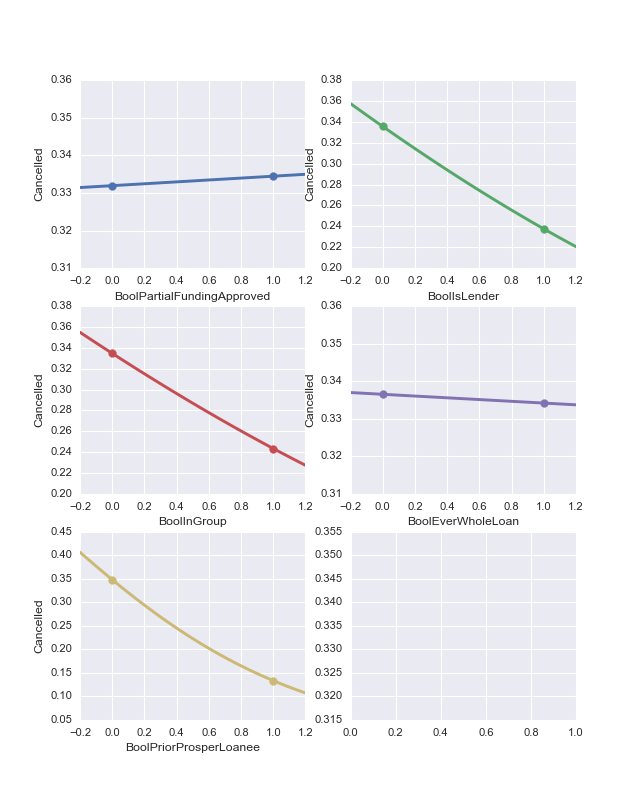

In [49]:
## create one big figure behind subpanels
fig, axes = plt.subplots(3,2,figsize=(8,10), facecolor='w')

## cycle through each numeric variable and logistic regress with cancellation (excluding cancellation itself)
for ax, var in zip(axes.reshape(-1), booleans.columns.values):
    sns.regplot(ax=ax, x=var, y="Cancelled", data=reduced_data, logistic=True, ci = None, x_bins = 1000)
    
## CONCLUSION: BoolIsLender and BoolInGroup highly significant, BoolPartialFundingApproved and BoolEverWholeLoan not.

In [29]:
print(x_range)

[[  2000.        ]
 [  2165.82914573]
 [  2331.65829146]
 [  2497.48743719]
 [  2663.31658291]
 [  2829.14572864]
 [  2994.97487437]
 [  3160.8040201 ]
 [  3326.63316583]
 [  3492.46231156]
 [  3658.29145729]
 [  3824.12060302]
 [  3989.94974874]
 [  4155.77889447]
 [  4321.6080402 ]
 [  4487.43718593]
 [  4653.26633166]
 [  4819.09547739]
 [  4984.92462312]
 [  5150.75376884]
 [  5316.58291457]
 [  5482.4120603 ]
 [  5648.24120603]
 [  5814.07035176]
 [  5979.89949749]
 [  6145.72864322]
 [  6311.55778894]
 [  6477.38693467]
 [  6643.2160804 ]
 [  6809.04522613]
 [  6974.87437186]
 [  7140.70351759]
 [  7306.53266332]
 [  7472.36180905]
 [  7638.19095477]
 [  7804.0201005 ]
 [  7969.84924623]
 [  8135.67839196]
 [  8301.50753769]
 [  8467.33668342]
 [  8633.16582915]
 [  8798.99497487]
 [  8964.8241206 ]
 [  9130.65326633]
 [  9296.48241206]
 [  9462.31155779]
 [  9628.14070352]
 [  9793.96984925]
 [  9959.79899497]
 [ 10125.6281407 ]
 [ 10291.45728643]
 [ 10457.28643216]
 [ 10623.115

<IPython.core.display.Javascript object>


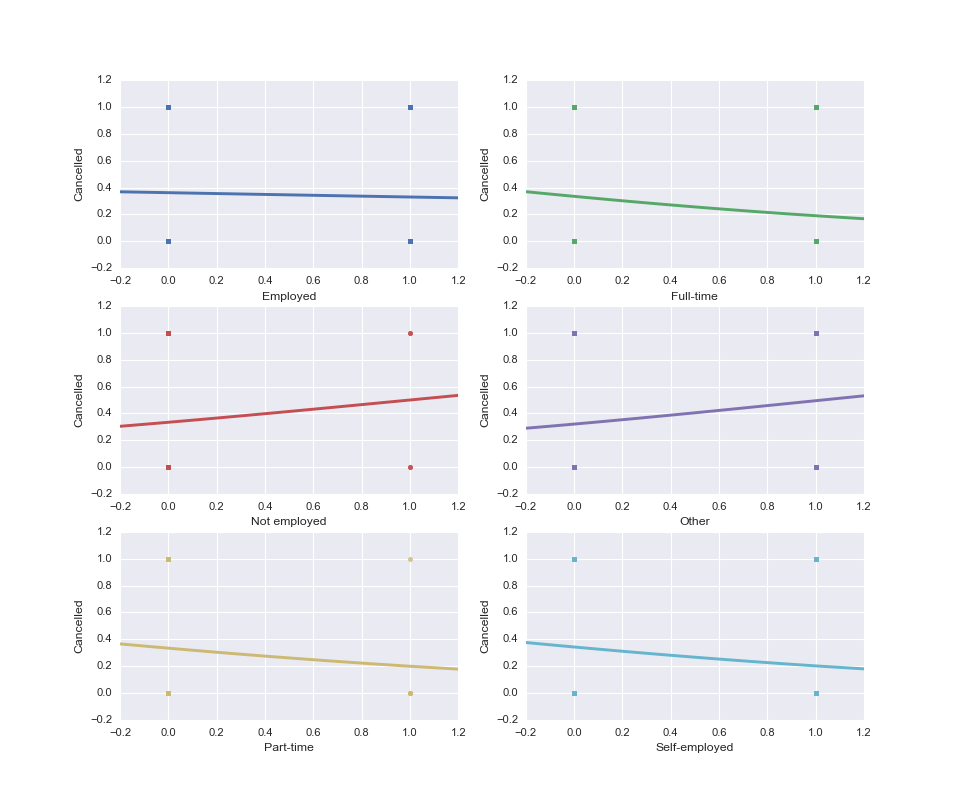

Employed         216678
Other             19544
Self-employed     15624
Full-time           614
Part-time             5
Not employed          4
Name: StrEmploymentStatus, dtype: int64

In [50]:
## 4 categorical variables left: EnumListingCategory, StrEmploymentStatus, StrOccupation, EnumChannelCode
# let's build a dummy variable for each, then see what the associated plots look like...although may have to take a
# different approach for occupation.
enum_listing_dummies = pd.get_dummies(reduced_data['StrEmploymentStatus'])
df = pd.concat([enum_listing_dummies, reduced_data['Cancelled']], axis =1)
fig, axes = plt.subplots(3,2,figsize=(12,10), facecolor='w')
df.head()

for ax, var in zip(axes.reshape(-1), df.columns):
    sns.regplot(ax=ax, x=var, y='Cancelled', data=df, logistic=True, ci = None)
    
reduced_data['StrEmploymentStatus'].value_counts()
    
## massive impact of taking employment status into account - listing "other" dramatically increases chances of not
## following through with loan, whereas having a "full-time" or "self-employed" status strongly increases chances.
## the change with employed looks small, but the sample size is huge, so very likely also significant.

In [51]:
df.head()

,Employed,Full-time,Not employed,Other,Part-time,Self-employed,Cancelled
ListingNumber,,,,,,,
973605,1,0,0,0,0,0,1
981099,0,0,0,1,0,0,1
1025766,1,0,0,0,0,0,0
1003835,1,0,0,0,0,0,1
1011335,1,0,0,0,0,0,0


In [52]:
## fold Part-time and Not employed into Other
df['Other'][df['Part-time'] == 1] = 1
df['Other'][df['Not employed'] == 1] = 1

df.drop(['Part-time','Not employed'], axis=1, inplace = True)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


<IPython.core.display.Javascript object>


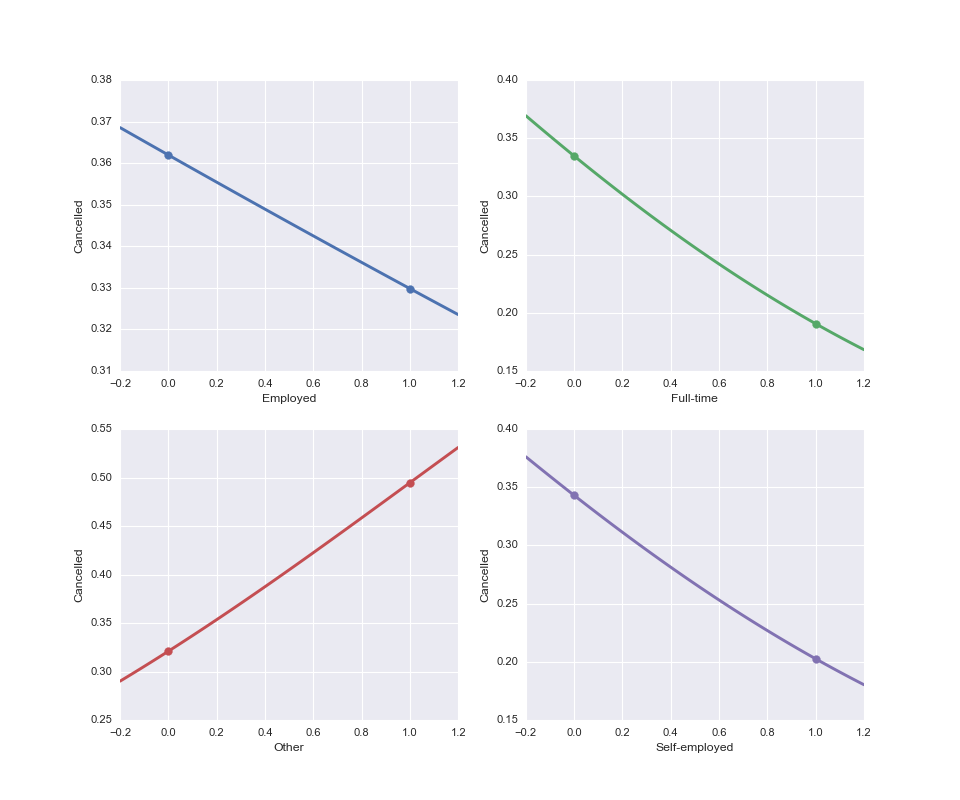

Employed         216678
Other             19544
Self-employed     15624
Full-time           614
Part-time             5
Not employed          4
Name: StrEmploymentStatus, dtype: int64

In [53]:
fig, axes = plt.subplots(2,2,figsize=(12,10), facecolor='w')

for ax, var in zip(axes.reshape(-1), df.columns):
    sns.regplot(ax=ax, x=var, y='Cancelled', data=df, logistic=True, ci = None, x_bins = 500)
    
reduced_data['StrEmploymentStatus'].value_counts()

## second major predictor - if employment status is "other", much less likely to follow through with loan.

In [ ]:
## save data as pickle file so we don't have to rerun this whole notebook every time.
reduced_data.to_pickle('loans_reduced.pkl')

In [55]:
g = reduced_data.groupby('EnumListingCategory')
print(g['Cancelled'].mean())
reduced_data['EnumListingCategory'].value_counts()

EnumListingCategory
0     0.355263
1     0.322420
2     0.352350
3     0.421997
6     0.374668
7     0.376605
8     0.330864
9     0.343750
11    0.336336
12    0.518182
13    0.343267
14    0.402126
15    0.394137
16    0.371429
17    0.410959
18    0.269542
19    0.431329
20    0.351734
21    0.244094
Name: Cancelled, dtype: float64


1     195363
7      17756
2      12638
3       6301
15      5356
14      4046
13      2718
6       2258
18      1484
20      1413
19      1347
8        405
11       333
16       280
0        228
9        160
17       146
21       127
12       110
Name: EnumListingCategory, dtype: int64

In [28]:
model = linear_model.LogisticRegression(C=.000001)
x = reduced_data['DolLoanAmountRequested'].to_frame()
y = reduced_data['EnumListingStatus'].to_frame()-6
mm = model.fit(x,y)
x_range = np.linspace(int(x.min()),int(x.max()),200).reshape([200,1])
probs = mm.predict_proba(x_range)
predicts = mm.predict(x_range)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [59]:
print(y)

               EnumListingStatus
ListingNumber                   
973605                         1
981099                         1
1025766                        0
1003835                        1
1011335                        0
1010105                        0
1029573                        0
1014296                        0
1009580                        0
743482                         1
1013984                        0
991147                         0
996748                         0
1020431                        0
1036179                        1
1036020                        0
1038345                        0
1042284                        0
1004506                        1
1004863                        1
1008013                        0
1026668                        1
1012066                        0
1061826                        0
1055967                        0
1041188                        0
1042166                        0
1061793                        0
1018846   

In [136]:
df2.columns

Index(['cat_0', 'cat_1', 'cat_2', 'cat_3', 'cat_6', 'cat_7', 'cat_8', 'cat_9',
       'cat_11', 'cat_12', 'cat_13', 'cat_14', 'cat_15', 'cat_16', 'cat_17',
       'cat_18', 'cat_19', 'cat_20', 'cat_21', 'Cancelled'],
      dtype='object')

1     195363
7      17756
2      12638
3       6301
15      5356
14      4046
13      2718
6       2258
18      1484
20      1413
19      1347
8        405
11       333
16       280
0        228
9        160
17       146
21       127
12       110
Name: EnumListingCategory, dtype: int64


<IPython.core.display.Javascript object>


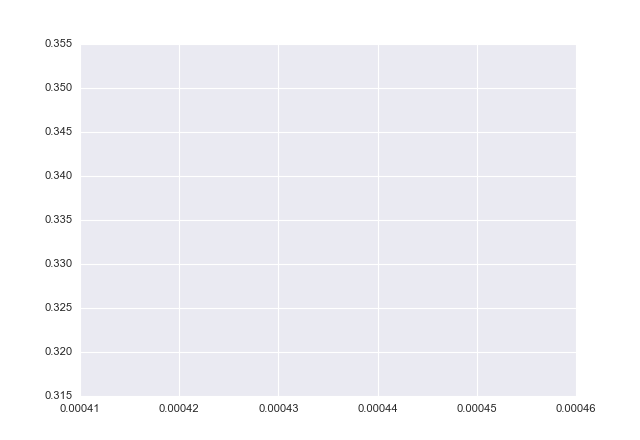

In [130]:
## 4 categorical variables left: EnumListingCategory, StrEmploymentStatus, StrOccupation, EnumChannelCode
enum_listing_dummies = pd.get_dummies(reduced_data['EnumListingCategory'], prefix = 'cat')
df2 = pd.concat([enum_listing_dummies, reduced_data['Cancelled']], axis =1)
print(reduced_data['EnumListingCategory'].value_counts())
fig, axes = plt.subplots()
#fig, axes = plt.subplots(5,4,figsize=(12,10), facecolor='w')
sns.regplot(ax=ax, x='cat_12', y='Cancelled', data=df2, logistic=True, ci = None)

#for ax, var in zip(axes.reshape(-1)[:-1], df.columns[:-1]):
#    sns.regplot(ax=ax, x=var, y='Cancelled', data=df, logistic=True)
    
## massive impact of taking employment status into account - listing "other" dramatically increases chances of not
## following through with loan, whereas having a "full-time" or "employed" status strongly increases chances.

In [ ]:
reduced_data['EnumChannelCode'].value_counts()

In [71]:
df.columns

Index([0, 1, 2, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       'Cancelled'],
      dtype='object')

,0,1,2,3,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21
ListingNumber,,,,,,,,,,,,,,,,,,,
973605,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
981099,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1025766,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1003835,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1011335,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1010105,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1029573,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1014296,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1009580,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
enum_listing_dummies

In [75]:
reduced_data['EnumListingCategory'].value_counts()

1     195363
7      17756
2      12638
3       6301
15      5356
14      4046
13      2718
6       2258
18      1484
20      1413
19      1347
8        405
11       333
16       280
0        228
9        160
17       146
21       127
12       110
Name: EnumListingCategory, dtype: int64